In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14501974854481459171
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8855182400
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9119717348798708932
physical_device_desc: "device: 0, name: GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)

In [5]:
stock_list = ['Alior Bank', 'Allegro', 'Asseco', 'CCC', 'CD Projekt', 'Cyfrowy Polsat', 'Dino Polska', 'JSW', 'KGHM', 'Lotos', 'LPP', 'Orange Polska', 'PEKAO', 'PGE', 'PGNiG', 'PKN Orlen', 'PKO BP', 'PZU', 'Santander', 'Tauron']

directory = "WiG20 data/"
stock_data_list = []

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    stock_data = pd.read_csv(file_path)
    stock_data = stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
    stock_data['Date'] = pd.to_datetime(stock_data.Date)
    stock_data_list.append(stock_data)
    print('Loaded file: ' + filename)

Loaded file: acp_d.csv
Loaded file: ale_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: cps_d.csv
Loaded file: dnp_d.csv
Loaded file: jsw_d.csv
Loaded file: kgh_d.csv
Loaded file: lpp_d.csv
Loaded file: lts_d.csv
Loaded file: opl_d.csv
Loaded file: peo_d.csv
Loaded file: pge_d.csv
Loaded file: pgn_d.csv
Loaded file: pkn_d.csv
Loaded file: pko_d.csv
Loaded file: pzu_d.csv
Loaded file: san_d.csv
Loaded file: tpe_d.csv


In [6]:
for i in range(len(stock_data_list)):
    stock_data_list[i] = stock_data_list[i].dropna()

In [7]:
def scale_data(data):
    list_of_features = []
    list_of_outputs = []
    for column in data.columns:
        list_of_features.append(data[column])
        if column in ['Open', 'Close', 'Highest', 'Lowest', 'Volume', 'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen']:
            list_of_outputs.append(data[column])
        
    dataset = np.transpose(list_of_features)
    output_dataset = np.transpose(list_of_outputs)
    X_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = X_scaler.fit_transform(dataset)
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler.fit_transform(output_dataset)

    return scaled_data, X_scaler, Y_scaler

In [8]:
def prepare_input_and_output(data, number_of_sessions=60):
    # number_of_sessions - number of considered previous sessions as an input
    X = []
    Y = []
    for i in range(number_of_sessions, data.shape[0]):
        X.append(data[i-number_of_sessions:i, :])
        Y.append(data[i, :5])
    return X, Y

In [9]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model

def evaluate_results(X_valid, Y_valid, Y_scalers, predictions):

    predictions = Y_scalers[0].inverse_transform(predictions)
    real_output = Y_scalers[0].inverse_transform(Y_valid)

    predicted_data = pd.DataFrame(predictions, columns=['Open_predicted', 'Close_predicted', 'Highest_predicted', 'Lowest_predicted', 'Volume_predicted'])
    real_data = pd.DataFrame(real_output, columns=['Open_real', 'Close_real', 'Highest_real', 'Lowest_real', 'Volume_real'])
    predictions = pd.concat([real_data, predicted_data], axis=1)
    print(predictions[['Close_real', 'Close_predicted']].tail(20))

    predictions['Close_difference'] = abs(predictions['Close_real'] - predictions['Close_predicted'])
    predictions['Close_difference_percent'] = abs(predictions['Close_real'] - predictions['Close_predicted'])/predictions['Close_real'] * 100

    previous_close = predictions['Close_real'].shift(-1)
    Naive_forcast_MAPE = (abs(predictions['Close_real'] - previous_close)/predictions['Close_real'] * 100).mean()
    predictions_MAPE = predictions['Close_difference_percent'].mean()

    print('Naive forcast MAE: ' + str(round(abs(previous_close - predictions['Close_real']).mean(),2)))
    print('Predictions MAE: ' + str(round(predictions['Close_difference'].mean(),2)))
    print('Naive forcast MAPE: ' + str(round(Naive_forcast_MAPE,2)) + '%')
    print('Predictions MAPE: ' + str(round(predictions_MAPE,2)) + '%')
    
    return predictions

In [10]:
scaled_stocks_basic = []
X_scalers_basic = []
Y_scalers_basic = []

for i in range(len(stock_data_list)):
    # Date is dropped as it isn't considered for learning
    scaled_stock, X_scaler, Y_scaler = scale_data(stock_data_list[i].drop(columns='Date'))
  
    scaled_stocks_basic.append(scaled_stock)
    X_scalers_basic.append(X_scaler)
    Y_scalers_basic.append(Y_scaler)

In [11]:
X_all_basic = []
Y_all_basic = []
scaled_X_list_basic = []
scaled_Y_list_basic = []

for stock in scaled_stocks_basic:
    X, Y = prepare_input_and_output(stock, 60)
    scaled_X_list_basic.append(np.array(X))
    scaled_Y_list_basic.append(np.array(Y))
    X_all_basic = X_all_basic + X
    Y_all_basic = Y_all_basic + Y

X_all_basic, Y_all_basic = np.array(X_all_basic), np.array(Y_all_basic)
print('Shape of input matrix: ' + str(X_all_basic.shape))
print('Shape of output matrix: ' + str(Y_all_basic.shape))

Shape of input matrix: (76328, 60, 5)
Shape of output matrix: (76328, 5)


In [12]:
X_train_basic, X_valid_basic, Y_train_basic, Y_valid_basic = train_test_split(X_all_basic, Y_all_basic, test_size=2667, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 24,925
Trainable params: 24,925
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2302/2302 [==============================] - 12s 4ms/step - loss: 0.0038 - val_loss: 3.7911e-04
Epoch 2/15
2302/2302 [==============================] - 9s 4ms/step - loss: 5.0395e-04 - val_loss: 3.5096e-04
Epoch 3/15
2302/2302 [==============================] - 8s 4ms/step - loss: 4.6550e-04 - val_loss: 3.9185e-04
Epoch 4/15
2302/2302 [==============================] -

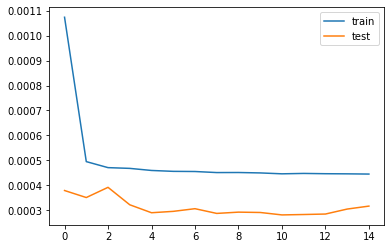

In [13]:
model_basic = Sequential()
model_basic.add(LSTM(64, input_shape=[X_train_basic.shape[1], X_train_basic.shape[2]]))#, return_sequences=True))
#model_basic.add(LSTM(64))
model_basic.add(Dense(100, activation='relu'))
model_basic.add(Dense(Y_train_basic.shape[1]))

model_basic.summary()

model_basic.compile(loss='mse', optimizer='adam')

history = model_basic.fit(X_train_basic, Y_train_basic, epochs=15, validation_data=(X_valid_basic, Y_valid_basic))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [14]:
predictions_basic = model_basic.predict(X_valid_basic)

predictions_basic = evaluate_results(X_valid_basic, Y_valid_basic, Y_scalers_basic, predictions_basic) # returns dataset

      Close_real  Close_predicted
2647   43.150455        43.702221
2648   43.190476        43.926373
2649   43.350559        43.242580
2650   44.711269        44.115105
2651   44.190997        44.765862
2652   42.990371        42.906231
2653   42.950351        43.096233
2654   42.590163        43.437290
2655   42.269996        42.353863
2656   42.390058        42.510765
2657   41.949829        42.395348
2658   41.589641        42.256435
2659   40.909286        41.379276
2660   39.628619        40.960918
2661   38.868222        39.616886
2662   37.987763        37.704502
2663   37.987763        37.936863
2664   37.947742        37.376347
2665   38.588076        38.559750
2666   38.387972        38.404530
Naive forcast MAE: 0.83
Predictions MAE: 0.66
Naive forcast MAPE: 1.96%
Predictions MAPE: 1.54%


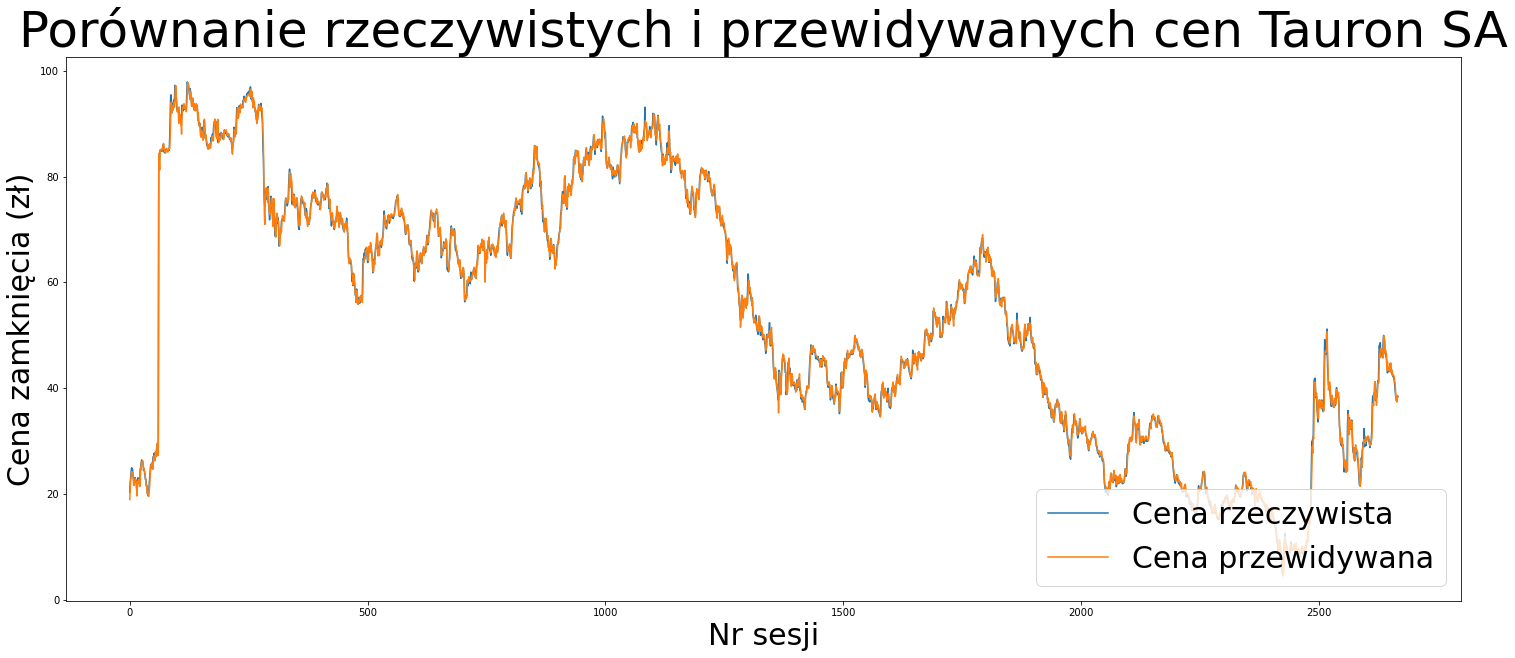

In [15]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych cen Tauron SA', fontsize=50)
plt.xlabel('Nr sesji', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(predictions_basic['Close_real'])
plt.plot(predictions_basic['Close_predicted'])
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()